In [1]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

In [2]:
# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [5]:
print(X.shape, y.shape)
X.head()

(506, 13) (506,)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [7]:
out = xgboost.DMatrix(X, label=y)
type(out)

xgboost.core.DMatrix

In [9]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [10]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

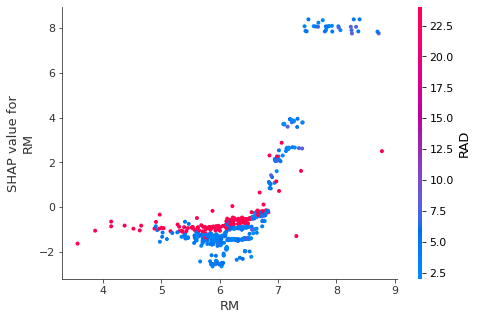

In [11]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)

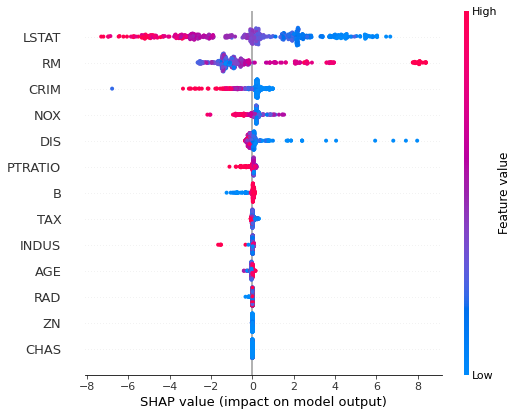

In [12]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

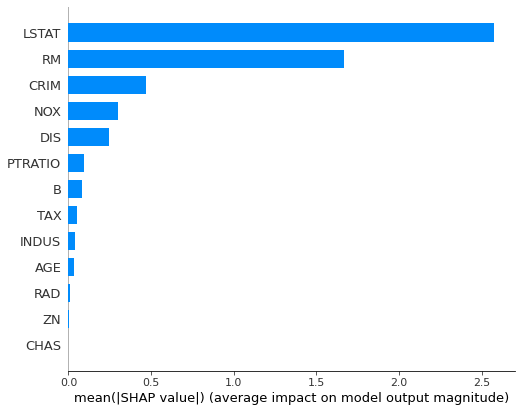

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [1]:
import os
import time
import numpy as np
import pandas as pd
#import modin.pandas as pd
import torch

from collections import Counter

In [2]:
data_x_path = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final2/ae/1000/final_allvocab_x_test.npy'
data_y_path = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final2/ae/1000/final_allvocab_y_test.npy'

features_path = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final2/ae/1000/100_features.txt'

vocab_path = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/ae_all_vocab_last180_whole'

num_features = 100

In [ ]:
x = Counter(np.load(data_x_path).flatten().tolist())
del x[0] # Remove 0 index (nan)
features = x.most_common(num_features)
features = [str(ft[0]) for ft in features]

In [ ]:
with open(features_path, 'w') as fp:
    fp.write('\n'.join(features))

In [ ]:
##Get indices for each month

In [ ]:
MONTH_INDX = 0
SPLIT_INDEX_DIR = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/xyz_split_index/'

TRAIN_DATA_PATH = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final-per-month/all/100/d_5990/train.csv'
TEST_DATA_PATH = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final-per-month/all/100/d_5990/val.csv'

OUTPUT_DATA_DIR = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final-per-month/monthly/100/d_5990/'
S3_OUTPUT_DATA_DIR = 's3://cmsai-mrk-amzn/CSVModelInputs/Tes/models/ae/final-per-month/data/100/d_5990/'

In [ ]:
month_splits = os.listdir(SPLIT_INDEX_DIR)
month_splits = [sp for sp in month_splits if 'npy' in sp]
train_month_splits = sorted([sp for sp in month_splits if 'train' in sp])
test_month_splits = sorted([sp for sp in month_splits if 'test' in sp])

In [ ]:
list(zip(train_month_splits, test_month_splits))

In [ ]:
month_train_index_path = os.path.join(SPLIT_INDEX_DIR, train_month_splits[MONTH_INDX])
month_test_index_path = os.path.join(SPLIT_INDEX_DIR, test_month_splits[MONTH_INDX])

In [ ]:
def get_num_patients(splits_dir, splits_fnames):
    """Get number of patients in each split/month"""
    num_patients = []
    for fname in splits_fnames:
        my_path = os.path.join(splits_dir, fname)
        num_patients.append(len(np.load(my_path).tolist()))
    return num_patients


def get_start_end_indices(train_num_patients, test_num_patients, month_indx):
    """Get the start and end indices for the given month index."""
    train_prev = sum(train_num_patients[:month_indx])
    test_prev = sum(test_num_patients[:month_indx])
    
    train_indices = (train_prev, train_prev+train_num_patients[month_indx])
    test_indices = (test_prev, test_prev+test_num_patients[month_indx])
    
    return [train_indices, test_indices]


def extract_monthly_data(indices, month_indx, train_data_path, test_data_path, output_dir, s3_output_dir):
    """Extract monthly data and save to file."""
    my_output_dir = os.path.join(output_dir, str(month_indx))
    if not os.path.exists(my_output_dir):
        os.makedirs(my_output_dir)

    train_indices = indices[0]
    test_indices = indices[1]
    
    print('Processing training data...')
    df = pd.read_csv(train_data_path, header=None)
    df = df.iloc[train_indices[0]:train_indices[1], :]
    output_path = os.path.join(my_output_dir, 'train.csv')
    df.to_csv(output_path, index=False, header=None)
    
    print('Processing validation data...')
    df = pd.read_csv(test_data_path, header=None)
    df = df.iloc[test_indices[0]:test_indices[1], :]
    output_path = os.path.join(my_output_dir, 'val.csv')
    df.to_csv(output_path, index=False, header=None) 
    
    print('Copying data to S3...')
    command = 'aws s3 cp --recursive --quiet {} {}'.format(output_dir, s3_output_dir)
    os.system(command)
    print('Data successfully copied to {}!'.format(s3_output_dir))

In [ ]:
train_num_patients = get_num_patients(SPLIT_INDEX_DIR, train_month_splits)
test_num_patients = get_num_patients(SPLIT_INDEX_DIR, test_month_splits)

In [ ]:
list(zip(train_num_patients, test_num_patients))

In [ ]:
indices = get_start_end_indices(train_num_patients, test_num_patients, MONTH_INDX)
indices

In [ ]:
indices = [(indices[0][0], indices[0][1]-20000), (indices[1][0], indices[1][1]-2000)]
indices

In [ ]:
from_imb = 1709955+21189
from_imb

In [ ]:
extract_monthly_data(indices, MONTH_INDX, TRAIN_DATA_PATH, TEST_DATA_PATH, OUTPUT_DATA_DIR, S3_OUTPUT_DATA_DIR)

In [ ]:
list(zip(train_num_patients, test_num_patients))

In [3]:
vocab = torch.load(vocab_path)

In [6]:
vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f4542599630>>,
            {'<pad>': 0,
             '<unk>': 1,
             'nan': 2,
             'h_99213': 3,
             'h_99214': 4,
             'h_36415': 5,
             'd_25000': 6,
             'p_D1E': 7,
             'd_4019': 8,
             'h_85025': 9,
             'h_80053': 10,
             'h_97110': 11,
             'd_4011': 12,
             'h_85610': 13,
             'h_99232': 14,
             'h_99212': 15,
             'd_42731': 16,
             'd_496': 17,
             'h_80061': 18,
             'h_G0154': 19,
             'd_2724': 20,
             'd_V0481': 21,
             'h_93010': 22,
             'h_98941': 23,
             'h_G0008': 24,
             'h_97140': 25,
             'h_71020': 26,
             'admission': 27,
             'h_71010': 28,
             'h_A4253': 29,
             'h_90658': 30,
             'discharge': 31,
             'h_9300

In [ ]:
vocab.freqs.most_common(10)

In [ ]:
#vocab.stoi

In [ ]:

    
# with open(features_path, 'r') as fp:
#     features = fp.readlines()
#     features = [int(ft.strip()) for ft in features]

# #y = np.load(data_y_path).flatten().tolist()

In [ ]:
1474322*500, 1474322*20

In [ ]:
for i, v in x.

In [ ]:
type(x.most_common(10)[0][0])

In [ ]:
#vocab.itos

In [ ]:
y = pd.DataFrame(y, columns=range(1, y.shape[1]+1))
print(y.shape)
y.head()

In [ ]:
x = pd.DataFrame(x, columns=range(1, x.shape[1]+1))
print(x.shape)
x.head()

In [ ]:
x_counts = x.value_counts()

In [ ]:
x_counts.shape

In [ ]:
x_counts

In [ ]:
preprocessed_dir = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/1000/all/feather-preprocessed/'
splits_index_dir = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/xyz_split_index/'
splits_output_dir = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/1000/all/preprocessed-splits/'

In [ ]:
def get_splits_index_fnames(splits_index_dir):
    """Get a list of splits indexes filenames for training and testing."""
    splits_index_fnames = {'train': [], 'val': []}
    fnames = os.listdir(splits_index_dir)
    splits_index_fnames['train'] = sorted([fname for fname in fnames if 'train' in fname])
    splits_index_fnames['val'] = sorted([fname for fname in fnames if 'test' in fname])    
    return splits_index_fnames


def get_preprocessed_fnames(preprocessed_dir):
    """Get list of preprocessed data filenames."""
    pre_fnames = {'train': [], 'val': []}
    fnames = os.listdir(preprocessed_dir)
    pre_fnames = [fname for fname in fnames if fname.endswith('.feather')]
    pre_fnames = sorted(pre_fnames)
    return pre_fnames


def split_data(df, sp_patients, remove_unavailable=True):
    """Splits patients data based on the given splits.
    Args:
        df(pd.DataFrame): Patients data
        sp_patients(Dict): Dictionary of list of splits for each split name
    Returns:
        Dictionary of pandas dataframes for each split
    """
    df_splits = {}
    num_patients = df.shape[0]
    for sp, inds in sp_patients.items(): 
        if remove_unavailable:
            inds = [ind for ind in inds if ind<num_patients]
        df_splits[sp] = df.iloc[inds]
    return df_splits


def get_splits_data(data_dir, splits_index_dir, output_dir):
    """Gets train/val data splits based on the given split indices"""
    print('Starting data splits processing...')
    preprocessed_fnames = get_preprocessed_fnames(preprocessed_dir)
    splits_index_fnames = get_splits_index_fnames(splits_index_dir)

    output_train_path = os.path.join(output_dir, 'train.csv')
    output_val_path = os.path.join(output_dir, 'val.csv')
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df_splits_all = {'train': None, 'val': None}
    for i, fname in enumerate(preprocessed_fnames):
        print('Splitting {}...'.format(fname))
        split_indices = {'train': [], 'val': []}
        
        data_path = os.path.join(data_dir, fname)
        df = pd.read_feather(data_path)
        
        train_splits_path = os.path.join(splits_index_dir, splits_index_fnames['train'][i])
        split_indices['train'] = np.load(train_splits_path)
        
        val_splits_path = os.path.join(splits_index_dir, splits_index_fnames['val'][i])
        split_indices['val'] = np.load(val_splits_path)
        
        splits = split_data(df, split_indices, remove_unavailable=True)
        for split_type, split in splits.items():
            if df_splits_all[split_type] is None:
                df_splits_all[split_type] = split.copy()
            else:
                df_splits_all[split_type] = pd.concat([df_splits_all[split_type], split], ignore_index=True, axis=0)
    df_splits_all['train'].to_csv(output_train_path, index=False)
    df_splits_all['val'].to_csv(output_val_path, index=False)
    print('Successfully created data splits and saved to {}!'.format(output_dir))    

In [ ]:
get_splits_data(preprocessed_dir, splits_index_dir, splits_output_dir)

In [ ]:
preprocessed_fnames = get_preprocessed_fnames(preprocessed_dir)
splits_index_fnames = get_splits_index_fnames(splits_index_dir)

In [ ]:
df = pd.read_feather(my_path)
print(df.shape)
df.head()

In [ ]:
def get_frequent_features(vocab, num_features, codes_only=True, exclusion_list=[]): 
    """Get the most frequent codes/features."""
    num_exc = len(exclusion_list) + 10
    features = vocab.freqs.most_common(num_features + num_exc)
    if codes_only:
        features = [word[0] for word in features if word[0] not in exclusion_list and ('_' in word[0])]
    else:
        features = [word[0] for word in features if word[0] not in exclusion_list]
    features = features[:num_features]
    return features


def get_one_hot_frequent_features(row, frequent_features, num_targets):
    """Gets one-hot encoding of the most frequent features of a given patient data
    Args:
        row(pd.Series): row to specify patient's specific adverse event
    Returns:
        Returns 0 if max value is 0 otherwise 1
    """
    pat_features = set(row[1:-num_targets])

    pat_labels = row[-num_targets:].tolist()
    pat_labels = [int(label) for label in pat_labels]
    #add extra label (adverse/not)
    pat_labels = pat_labels + [int(1 in pat_labels)]
        
    one_hot = [int(ft in row) for ft in frequent_features]
    one_hot = one_hot + pat_labels
    return one_hot


def preprocess(args):
    data_path, output_path, vocab, num_features, num_targets, sample_size, codes_only = args
    print('Started preprocessing {}...'.format(data_path))
    df = pd.read_feather(data_path)
    targets = df.columns[-num_targets:].tolist()
    exclusion_list = targets + ['nan', 'pad', 'unk']
    features = get_frequent_features(vocab, num_features, codes_only, exclusion_list)
    columns = features + targets + ['adverse']
    if sample_size is not None:
        df = df.iloc[:sample_size]
    df = df.apply(get_one_hot_frequent_features, axis=1, args=(features, num_targets))
    df = pd.DataFrame(df.tolist(), columns=columns)
    
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    df.to_feather(output_path)
    print('Successfully preprocessed and Saved to {}!'.format(output_path))
    
def preprocess_all(data_dir, output_dir, vocab, num_features, num_targets, sample_size=None, codes_only=True):
    if not os.path.exists(data_dir):
        raise ValueError('Error! {} does not exist!'.format(data_dir))
        
    fnames = os.listdir(data_dir)
    fnames = [fname for fname in fnames if os.path.isfile(os.path.join(data_dir, fname))]
    fnames = sorted(fnames)
    num_cpus = len(fnames)
    
    #Parallelize
    pool = mp.Pool(num_cpus)
    data_paths = [os.path.join(data_dir, fname) for fname in fnames]
    output_paths = [os.path.join(output_dir, fname) for fname in fnames]
    
    my_args = [(data_paths[i], output_paths[i], vocab, num_features, num_targets, sample_size, codes_only) for i in range(len(fnames))]
    pool.map(preprocess, my_args)
    pool.close()
    
    #Non-parallelized
    #for fname in fnames[:2]:
    #    data_path = os.path.join(data_dir, fname)
    #    output_path = os.path.join(output_dir, fname)
    #    
    #    preprocess(data_path, output_path, vocab, num_features, num_targets, sample_size, codes_only)
    
    
#Next...
#1. Save to py file
#2. Run it in tmux
#3. Make it flexible with re/ae
#4. Add data splitting and merging module
#5. Modify the xgboost training (including the labels weights)
#6. Put the input in config (may be..)

In [ ]:
DATA_DIR = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/1000/all/feather/'
OUTPUT_DIR = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/1000/all/feather-preprocessed/'
VOCAB_PATH = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/ae_all_vocab_last180_whole'
SPLIT_INDEX_DIR = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/final/ae/xyz_split_index/'

NUM_FREQUENT_FEATURES = 1000
NUM_TARGETS = 20

#Number of examples to take (if None, it takes all examples)
SAMPLE_SIZE = 100
MEDICAL_CODES_ONLY = True

In [ ]:
# train_path = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/new/xyz_ae_split_index/train_index_ae_patients_365_20110101.npy'
# test_path = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/new/xyz_ae_split_index/test_index_ae_patients_365_20110101.npy'
# train = np.load(train_path)
# test = np.load(test_path)

In [ ]:
#cols = ['h_99213', 'h_99214', 'h_36415', 'd_25000', 'p_D1E', 'd_4019', 'h_85025', 'h_80053', 'h_97110', 'd_4011', 'h_85610', 'h_99232', 'h_99212', 'd_42731', 'd_496', 'h_80061', 'h_G0154', 'd_2724', 'd_V0481', 'h_93010', 'h_98941', 'h_G0008', 'h_97140', 'h_71020', 'h_71010', 'h_A4253', 'h_90658', 'h_93000', 'd_7242', 'h_92014', 'p_D1C', 'd_V5861', 'h_83036', 'h_99233', 'h_E1390', 'd_7393', 'd_5990', 'd_41401', 'h_88305', 'd_78650', 'h_84443', 'h_80048', 'd_4280', 'h_99215', 'h_A0425', 'h_99211', 'h_99203', 'h_G0151', 'd_1101', 'd_5856', 'h_99204', 'd_V5869', 'h_99285', 'd_2859', 'd_2720', 'h_96372', 'd_25002', 'h_G8447', 'h_G0156', 'd_78079', 'd_32723', 'd_2449', 'h_99223', 'h_11721', 'd_78605', 'd_7391', 'd_7295', 'h_99308', 'h_A4259', 'h_G8553', 'h_99231', 'h_92012', 'd_36616', 'h_93306', 'd_V7612', 'h_98940', 'd_7020', 'd_41400', 'h_G0283', 'h_81001', 'd_71946', 'h_99284', 'h_90806', 'h_97112', 'h_90999', 'h_97530', 'd_486', 'd_78900', 'h_99222', 'h_77052', 'h_90862', 'h_G0202', 'h_99309', 'd_185', 'p_D1F', 'h_92015', 'd_7812', 'd_71941', 'h_20610', 'h_E0431', 'h_87086', 'h_17000', 'h_82306', 'h_70450', 'd_72252', 'h_99283', 'h_81003', 'd_7862', 'd_2722', 'd_7231', 'd_36511', 'd_71516', 'd_25001', 'd_7244', 'h_G8445', 'd_71945', 'h_81002', 'h_83540', 'd_2809', 'p_O1E', 'h_A0427', 'h_A4256', 'h_E0570', 'h_97035', 'd_78609', 'h_92135', 'h_A0428', 'd_7804', 'p_D1G', 'p_D1D', 'd_7802', 'h_Q4081', 'h_81000', 'd_53081', 'd_49390', 'd_7823', 'd_71596', 'h_99202', 'h_Q0513', 'h_99238', 'd_5849', 'h_85027', 'h_99205', 'd_4439', 'h_84153', 'h_J3420', 'd_311', 'd_4660', 'd_2382', 'd_72402', 'd_5853', 'd_28521', 'd_7245', 'd_79902', 'h_93880', 'h_82728', 'd_73300', 'h_99307', 'h_17003', 'd_7140', 'h_P9603', 'h_83550', 'h_84439', 'd_1749', 'd_49121', 'h_77080', 'h_E0601', 'd_51881', 'h_80076', 'd_7840', 'd_72887', 'd_7197', 'd_71590', 'h_82570', 'h_A4657', 'd_436', 'h_11100', 'd_7392', 'h_G8427', 'h_78452', 'd_2689', 'd_78659', 'd_36252', 'h_P9604', 'h_82607', 'd_V431', 'h_82962', 'd_43310', 'h_92083', 'd_7213', 'h_97001', 'h_82947', 'd_36251', 'h_82565', 'd_29570', 'h_73510', 'h_97116', 'd_4779', 'h_A0429', 'h_99239', 'h_92004', 'h_99291', 'd_7291', 'd_79431', 'd_78720', 'd_73390', 'd_4770', 'h_11720', 'h_82550', 'h_87088', 'd_51889', 'd_4241', 'd_3804', 'd_78791', 'h_4048F', 'h_1000F', 'h_95117', 'd_5119', 'h_J3301', 'd_3310', 'h_84100', 'd_V700', 'd_4240', 'd_25060', 'd_2662', 'd_43491', 'h_73030', 'd_60000', 'd_V5883', 'd_42781', 'h_92250', 'h_83735', 'h_72100', 'h_J2501', 'h_93005', 'h_97032', 'd_60001', 'h_73630', 'd_78097', 'h_83970', 'd_72210', 'h_E0260', 'h_66984', 'd_4659', 'd_42789', 'd_6929', 'h_11056', 'd_78039', 'd_71947', 'd_4254', 'h_1036F', 'd_29633', 'd_79093', 'd_7243', 'd_7851', 'h_72193', 'd_29632', 'h_84460', 'h_77003', 'd_70219', 'd_2113', 'h_J7613', 'h_84550', 'p_D1B', 'd_3320', 'd_6826', 'd_78701', 'd_V4365', 'h_87186', 'h_74160', 'd_7906', 'd_1733', 'h_90960', 'd_7224', 'h_2027F', 'h_51798', 'h_98942', 'd_44020', 'h_73560', 'd_5859', 'd_70211', 'd_7394', 'd_78060', 'h_00142', 'd_4139', 'h_J7620', 'd_70715', 'd_71509', 'd_5789', 'd_37515', 'h_A4258', 'd_72610', 'd_78841', 'd_V5789', 'd_4619', 'd_58881', 'h_71260', 'd_V7644', 'h_82310', 'd_7030', 'h_72170', 'h_84450', 'h_2019F', 'h_94760', 'h_90805', 'h_82043', 'd_56400', 'h_G0152', 'd_59970', 'd_1629', 'd_36501', 'h_93015', 'd_V7283', 'h_99221', 'd_40210', 'h_K0001', 'h_J1270', 'd_4359', 'h_93971', 'h_11719', 'd_56210', 'd_78820', 'h_73562', 'h_96413', 'h_43239', 'h_G8443', 'd_30000', 'h_90801', 'd_2761', 'd_72981', 'd_4010', 'd_27651', 'd_7931', 'h_J1100', 'h_93970', 'd_V762', 'h_69210', 'h_74150', 'h_G0179', 'h_72192', 'h_3120F', 'h_90656', 'h_84132', 'h_96365', 'h_74000', 'd_7234', 'h_87077', 'h_84520', 'd_2948', 'd_7038', 'h_82746', 'd_5854', 'h_17110', 'd_29530', 'h_J1030', 'd_7813', 'd_5939', 'h_97012', 'h_84436', 'h_90853', 'h_G0180', 'd_V420', 'h_G0101', 'h_36416', 'd_4149', 'd_5920', 'd_V1083', 'h_67028', 'h_85652', 'd_V7231', 'h_90471', 'd_4778', 'h_83615', 'd_36653', 'd_4279', 'h_Q9967', 'd_5180', 'd_V7651', 'd_8208', 'd_V4501', 'd_3540', 'h_G8448', 'd_41519', 'h_G0103', 'd_4928', 'h_71250', 'h_G8446', 'h_Q0092', 'h_94010', 'h_90816', 'h_95115', 'd_78907', 'h_Q5001', 'h_72148', 'h_92226', 'h_A7038', 'h_82248', 'h_90818', 'h_J1040', 'd_78909', 'd_V7281', 'h_85730', 'd_25070', 'h_90732', 'h_97010', 'd_4293', 'h_93018', 'd_7881', 'd_V5811', 'h_77418', 'h_00810', 'h_J1756', 'd_2810', 'h_94060', 'd_2989', 'h_83880', 'd_71536', 'h_85651', 'd_7993', 'd_7210', 'd_V571', 'd_78651', 'h_92136', 'h_77051', 'h_A7003', 'd_V0382', 'd_37921', 'h_Q0091', 'h_92557', 'h_73610', 'd_36610', 'd_3669', 'd_79029', 'h_77057', 'h_99000', 'd_3569', 'h_A7037', 'd_6829', 'h_4011F', 'd_78830', 'd_78906', 'h_93016', 'd_340', 'h_99397', 'd_1539', 'd_5589', 'h_97535', 'h_A7035', 'd_45340', 'd_3004', 'd_490', 'h_88304', 'd_0389', 'd_2768', 'h_76700', 'd_7820', 'h_83721', 'h_76770', 'h_11042', 'd_7265', 'h_86140', 'd_72885', 'h_76942', 'h_93280', 'h_93293', 'h_87070', 'h_3342F', 'd_7241', 'd_2572', 'h_Q1003', 'h_82270', 'd_78321', 'd_2811', 'd_2767', 'h_99306', 'd_95901', 'd_71515', 'd_700', 'h_88312', 'h_72110', 'h_A7034', 'h_G0431', 'd_49120', 'd_72871', 'h_85018', 'd_7354', 'h_88342', 'h_62311', 'd_71595', 'd_V7284', 'd_4111', 'd_29630', 'd_7011', 'h_99349', 'd_20280', 'd_1889', 'h_G0009', 'p_O1C', 'h_45380', 'h_90807', 'h_A5500', 'h_70553', 'h_G0164', 'h_87340', 'd_586', 'p_D1A', 'd_4414', 'd_2749', 'd_30002', 'd_44021', 'd_73301', 'd_8404', 'h_E0143', 'h_97150', 'h_4047F', 'h_00740', 'h_52000', 'd_25050', 'd_25040', 'h_76705', 'd_462', 'd_78009', 'h_4177F', 'h_A9500', 'd_36619', 'h_73564', 'h_97124', 'h_77421', 'h_76645', 'd_V5881', 'h_45378', 'h_11055', 'h_K0003', 'h_80069', 'd_45981', 'h_G0145', 'h_88112', 'd_4148', 'd_78843', 'd_7062', 'd_4589', 'h_90662', 'd_56211', 'h_R0070', 'h_77427', 'd_8472', 'd_4271', 'd_36256', 'd_V5481', 'h_99310', 'd_2869', 'h_96374', 'd_40290', 'd_29590', 'h_73110', 'd_42732', 'h_E0562', 'd_61172', 'h_1123F', 'd_29680', 'd_20300', 'd_5693', 'd_V4364', 'h_90804', 'h_G0206', 'd_49300', 'h_G0157', 'h_J0696', 'd_60784', 'h_K0195', 'd_71690', 'd_4739', 'd_53550', 'h_96375', 'd_6961', 'd_36500', 'h_3341F', 'h_70551', 'd_53011', 'd_30928', 'h_J0885', 'd_36510', 'h_84165', 'd_78702', 'd_25003', 'd_2900', 'd_7821', 'h_73130', 'd_70714', 'h_74022', 'd_36615', 'h_84484', 'd_7395', 'h_A9270', 'd_2851', 'd_8470', 'd_5609', 'd_57420', 'd_78053', 'd_79021', 'd_71944', 'h_95904', 'h_G0127', 'h_90935', 'd_5781', 'h_E0443', 'h_99282', 'd_7859', 'd_2165', 'd_V103', 'h_G0155', 'h_92020', 'h_99217', 'h_82040', 'd_25080', 'd_71500', 'h_17004', 'd_59972', 'd_78901', 'h_74170', 'h_J7626', 'h_64483', 'd_78093', 'd_99591', 'h_77014', 'd_78821', 'h_94720', 'd_71949', 'h_J0702', 'd_V1272', 'h_74020', 'd_71943', 'h_45385', 'h_J7050', 'h_88313', 'd_6272', 'd_78057', 'h_76775', 'd_71591', 'h_92567', 'h_4256F', 'h_99336', 'd_72283', 'h_4040F', 'd_514', 'h_11101', 'h_99305', 'd_1744', 'h_2022F', 'd_5770', 'd_71940', 'h_93923', 'h_G0204', 'h_20550', 'd_36250', 'h_72125', 'd_515', 'd_78052', 'h_K0004', 'h_99335', 'd_4292', 'd_68111', 'd_3674', 'h_84479', 'h_93042', 'd_5932', 'h_73620', 'h_84403', 'd_72761', 'd_71511', 'd_7262', 'd_41071', 'h_94640', 'h_80051', 'h_J1885', 'h_K0738', 'h_76536', 'd_7850', 'h_72040', 'd_042', 'd_29634', 'h_93510', 'p_9904', 'd_3051', 'd_36201', 'h_82378', 'h_93922', 'h_82150', 'd_2875', 'd_49320', 'd_V443', 'h_11730', 'd_33829', 'h_73721', 'd_30981', 'd_6827', 'd_70710', 'h_90945', 'h_93798', 'h_95165', 'h_82977', 'd_7282', 'd_V433', 'd_1736', 'h_J2405', 'h_93925', 'd_38910', 'h_97113', 'h_86038', 'd_2800', 'd_59971', 'd_29411', 'h_96367', 'h_0014F', 'd_7220', 'd_78831', 'd_6273', 'h_88307', 'd_8360', 'h_99201', 'h_71275', 'h_J2250', 'd_34590', 'h_85045', 'd_5533', 'h_31575', 'h_92134', 'h_76519', 'h_Q0511', 'd_20410', 'h_99220', 'h_4250F', 'h_G0163', 'h_95903', 'd_9597', 'd_29690', 'h_66821', 'd_V7641', 'h_83690', 'h_76856', 'd_7847', 'h_92235', 'd_7350', 'd_33818', 'h_99348', 'h_84480', 'd_25062', 'h_E0607', 'd_V4581', 'd_37924', 'h_85014', 'd_3384', 'h_11040', 'd_40390', 'h_82948', 'h_93545', 'h_A4235', 'd_70705', 'h_84155', 'd_5070', 'd_27800', 'd_36504', 'h_E0470', 'd_V4502', 'h_A5512', 'h_72141', 'd_7852', 'd_37300', 'h_94240', 'h_10060', 'h_J7321', 'd_78904', 'h_88311', 'h_A7030', 'd_25090', 'h_51741', 'h_92225', 'h_6045F', 'd_70703', 'd_79389', 'h_J3010', 'h_84075', 'd_23875', 'd_4539', 'h_A9502', 'h_3017F', 'd_1748', 'h_96415', 'd_2410', 'h_80154', 'd_81342', 'd_70909', 'd_2769', 'd_79380', 'd_38918', 'd_1985', 'd_78652', 'h_Q0512', 'h_90961', 'd_73313', 'h_72050', 'd_78703', 'd_43330', 'h_G0328', 'd_V7611', 'd_78002', 'h_93288', 'd_1541', 'h_17311', 'd_59654', 'h_J7644', 'h_A9579', 'd_1830', 'd_1623', 'd_40391', 'd_5950', 'h_J0881', 'd_27801', 'd_36617', 'd_29620', 'd_7866', 'h_93296', 'd_2865', 'h_4255F', 'h_76830', 'd_920', 'h_J7507', 'd_725', 'd_7292', 'd_07810', 'd_7099', 'd_29689', 'd_2411', 'd_28860', 'h_E0434', 'd_4270', 'd_4260', 'd_69274', 'h_85007', 'd_7230', 'd_V5882', 'd_1735', 'd_99673', 'd_0539', 'h_11041', 'd_2819', 'h_80162', 'd_591', 'h_70486', 'd_42822', 'd_412', 'd_5921', 'd_82021', 'd_7202', 'd_78903', 'h_97597', 'd_7962', 'd_29410', 'h_B4035', 'h_99350', 'h_78815', 'd_61610', 'h_82784', 'h_86141', 'h_97002', 'd_72400', 'h_77413', 'h_92526', 'h_G0181', 'h_73550', 'd_7842', 'd_34830', 'd_6822', 'd_27542', 'd_V5331', 'h_82553', 'd_72703', 'd_28529', 'd_49392', 'h_73500', 'h_82465', 'd_4720', 'h_3100F', 'd_00845', 'd_4371', 'h_84156', 'h_20605', 'd_84500', 'd_1734', 'h_73221', 'd_71906', 'd_V4589', 'd_2392', 'd_53500', 'd_71597', 'h_74177', 'h_93325', 'd_6259', 'h_A4595', 'd_4168', 'h_99144', 'd_78099', 'h_3048F', 'h_73590', 'd_72690', 'd_7907', 'd_1104', 'h_99183', 'h_84466', 'd_5715', 'h_84295', 'h_82247', 'd_3090', 'h_95900', 'h_36620', 'h_77336', 'h_96361', 'd_36257', 'h_J3490', 'd_5641', 'd_6256', 'd_53510', 'd_24290', 'h_A7032', 'h_84481', 'd_51884', 'd_55090', 'd_7260', 'd_43820', 'd_25042', 'd_1890', 'h_J2785', 'h_83718', 'h_V2020', 'd_71942', 'h_64493', 'd_78799', 'd_4281', 'd_36283', 'd_7856', 'h_J9035', 'd_34690', 'd_7068', 'd_69010', 'h_96366', 'h_2021F', 'd_2448', 'h_87205', 'h_78306', 'h_E0163', 'h_98943', 'h_99334', 'd_7246', 'h_31231', 'd_81200', 'h_97014', 'h_95811', 'd_7873', 'h_A5513', 'd_7100', 'h_43235', 'h_J2778', 'h_J1200', 'd_2967', 'd_42823', 'h_11057', 'h_A7005', 'h_80185', 'p_3893', 'd_2163', 'h_3044F', 'd_6869', 'h_93543', 'h_94762', 'h_96402', 'd_4580', 'h_88175', 'd_99859', 'h_G8482', 'h_G9141', 'd_2639', 'd_5855', 'h_99219', 'h_86334', 'd_29623', 'h_77414', 'h_92507', 'd_4829', 'd_29021', 'h_80164', 'h_E0439', 'h_82272', 'd_36253', 'd_36202', 'h_82145', 'd_8910', 'd_95909', 'd_29622', 'd_45119', 'd_82525', 'd_5990', 'd_78605', 'd_486', 'd_78650', 'd_78079', 'd_78900', 'd_78609', 'd_7862', 'd_1101', 'd_78701', 'd_5789', 'd_78791', 'd_6826', 'd_78659', 'd_78907', 'd_7840', 'd_28860', 'd_4660', 'd_6829', 'd_00845', 'adverse']
#len(cols)

In [ ]:
#from collections import Counter
#ctr = Counter(cols)
#ctr.most_common(1000)

In [ ]:
#Load Vocabulary object
vocab = torch.load(VOCAB_PATH)

In [ ]:
#Preprocess the files
start = time.time()
preprocess_all(DATA_DIR, OUTPUT_DIR, vocab, NUM_FREQUENT_FEATURES, NUM_TARGETS, SAMPLE_SIZE, MEDICAL_CODES_ONLY)
print('Total time: {:.2f} mins.'.format((time.time()-start)/60.0))

In [ ]:
output_path = os.path.join(OUTPUT_DIR, FNAME)
df = pd.read_feather(output_path)
print(df.shape)
df.head()

In [ ]:
import time
t1 = time.time()

num_features=100
only_codes=True
df = preprocess(data_path, vocab, num_features, only_codes)
print('Total time: {:.2f} mins.'.format((time.time()-t1)/60.0))
print(df.shape)
df.head()

In [ ]:
import time
t1 = time.time()
num_features = 100
features = get_frequent_features(vocab, num_features, only_codes=True)
target_cols = df.columns[-20:].tolist()
df2 = df.apply(get_one_hot_frequent_features, axis=1)
df2 = pd.DataFrame(df2.tolist(), columns=features+target_cols)
print('Total time: {:.2f} mins.'.format((time.time()-t1)/60.0))
print(df.shape, df2.shape)
df2.head()

In [ ]:
#vocab.stoi

In [ ]:
type(vocab.freqs)

In [ ]:
orig_data_path = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/new/1000-feather/ae_patients_1000_20110101.feather'
data_path = '/home/ec2-user/SageMaker/CMSAI/modeling/tes/data/new/1000/ae_patients_1000_20110101.csv'

In [ ]:
df = pd.read_feather(orig_data_path)

In [ ]:
print(df.shape)
df.head()

In [ ]:
import torchtext
from torchtext import data

In [ ]:
pos = data.TabularDataset(
    path=data_path, format='csv',
    fields=[('text', data.Field()),
            ('labels', data.Field())])